# TWITTER HASH TAG PREDICTION AND ANALYSIS WITH TWITTER DATA WITH MACHINE LEARNING  
               



In [ ]:
# import packages

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [ ]:
pip install pydataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939433 sha256=a80ccd8ab37cb366080a670f50ee4f6f63aad9015bafc513c7fb9895530ec6ac
  Stored in directory: /root/.cache/pip/wheels/6b/86/a7/f71cb84c7bff804d83e293615a20c0531234397b796aee2645
Successfully built pydataset


In [ ]:
from pydataset import data
from sklearn.ensemble        import BaggingClassifier, \
         ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import RidgeClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import json

import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Twitter_Weather_ML/twitter_weather_data.csv')



Mounted at /content/drive


In [ ]:
# set up label dataframe for future refrences

label = [-1, 0, 1, 2]
labelN = ["Anti", "Neutral", "Pro", "News"]
labelDesc = [
    "the tweet does not believe in man-made climate change"
    , "the tweet neither supports nor refutes the belief of man-made climate change"
    , "the tweet supports the belief of man-made climate change"
    , "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"])

## Data Dictionary

In [ ]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


## Distribution of Sentiments

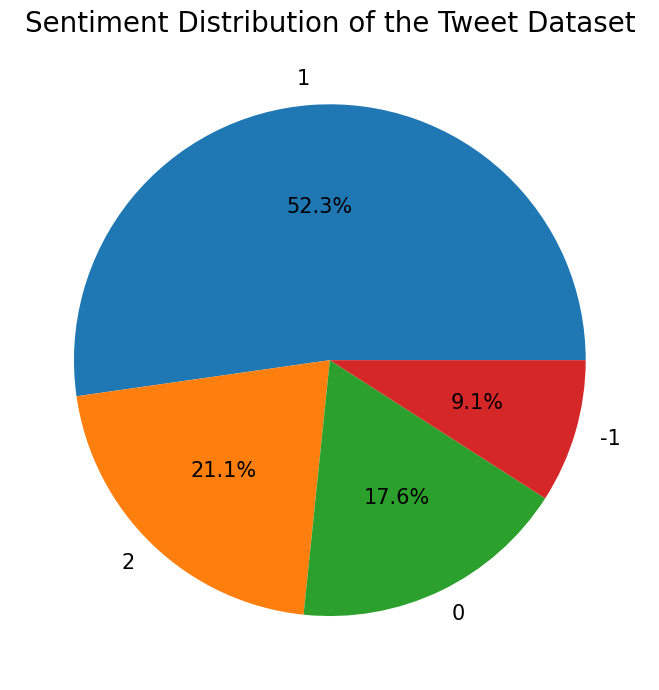

 "1"  positive attitude toward the belief that the climate change is caused by the man-kinds, followed by "2"(news), "0"(neutral), and "-1"(anti).


In [ ]:
plt.figure(figsize = (7, 7))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index, autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()

print(' "1"  positive attitude toward the belief that the climate change is caused by the man-kinds, followed by "2"(news), "0"(neutral), and "-1"(anti).')

In [ ]:
df.sentiment.value_counts()

 1    22962
 2     9276
 0     7715
-1     3990
Name: sentiment, dtype: int64

In [81]:
# separate the messages column for transformation.
dfTweets = df["message"]

## Tokenization ( tweets are first split into arrays of words.)


In [ ]:
def createTokenizedArray(sentences):

    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r'\w+')
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [ ]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4    [rt, cnalive, pranita, biswasi, a, lutheran, from, odisha, gives, testimony, on, effec...
dtype: object

## Stop Word Removal
eg: "the", "a", and "an"

In [ ]:
# To get stop words.
nltk.download('stopwords')

def removeStopWords(tokenList):
    '''
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    '''
    stopWords = set(stopwords.words('english'))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:

                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if (len(word) > 1 and word.isdigit() == False):
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

In [ ]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


## Stemming


In [ ]:
def stemWords(sentenceArrays):
    '''
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    '''
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimeter = ' '
        sentence = delimeter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [ ]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom


## Vectorization


In [ ]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    '''
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    '''
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [ ]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

In [ ]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


In [ ]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
  (0, 10652)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 24524)	1
  (0, 27759)	1
  (0, 29419)	1
  (0, 45475)	1
  (0, 54598)	1
  (0, 55193)	1
  (0, 57219)	1
  (0, 61855)	1
  (0, 64839)	1
#2 after vectorization:
  (0, 9419)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 14222)	1
  (0, 27583)	1
  (0, 27591)	1
  (0, 35060)	1
  (0, 35653)	1
  (0, 40355)	1
  (0, 49581)	1
  (0, 50386)	1
  (0, 55654)	1
  (0, 57882)	1
  (0, 61927)	1
  (0, 63129)	1


In [ ]:
vectorizedTweets.shape

(43943, 67195)

## Bi-Grams
group N numbers of words together and analyze their frequencies 

In [ ]:
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf['sentiment'] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf['transformedTweets']]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = ' '
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram" : delimiter.join(counterList[i][0])
            ,"Occurrences" : counterList[i][1]
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [ ]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the stemmed data.
df['transformedTweets'] = stemmedLi
dfSub = df[['sentiment', 'transformedTweets']]

### Top 20 Occurrences  Anti Climate Change Tweets (-1)


***N-Gram (Sentiment: -1)
                N-Gram  Occurrences
0         climat chang         2211
1              http co         1873
2          global warm         1855
3             man made          174
4           chang http          150
5     rt stevesgoddard          118
6            warm http          114
7              al gore          103
8              http rt           91
9   rt realdonaldtrump           87
10         made climat           86
11         made global           73
12             warm rt           72
13            chang rt           66
14          chang real           65
15         warm climat           61
16           warm hoax           60
17       believ climat           54
18          chang hoax           53
19         caus global           48


<Axes: title={'center': 'Top 20 Occurrences of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

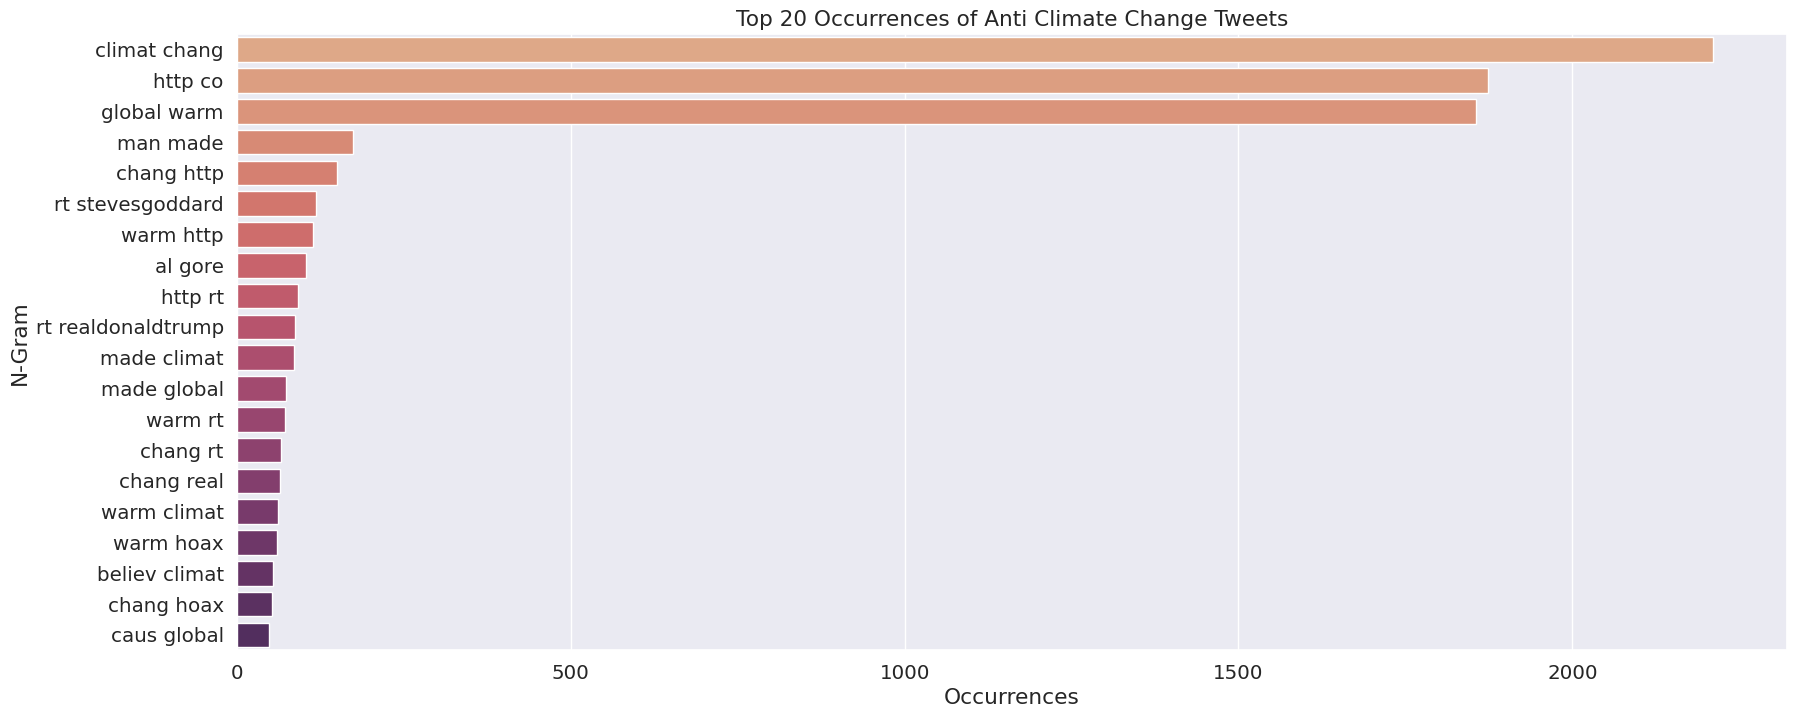

In [ ]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

### Top 20 Occurrences of Neutral Climate Change Tweets (0)


***N-Gram (Sentiment: 0)
           N-Gram  Occurrences
0    climat chang         4491
1         http co         3271
2     global warm         3109
3      chang http          447
4       warm http          289
5         warm rt          236
6        chang rt          218
7     caus global          137
8       warm real          121
9         http rt          109
10  believ climat          107
11    talk climat           99
12          ðÿ ðÿ           88
13   think global           82
14   club penguin           82
15     chang real           81
16  believ global           75
17    caus climat           70
18   penguin shut           68
19     chang hoax           63


<Axes: title={'center': 'Top 20 Occurrences of  Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

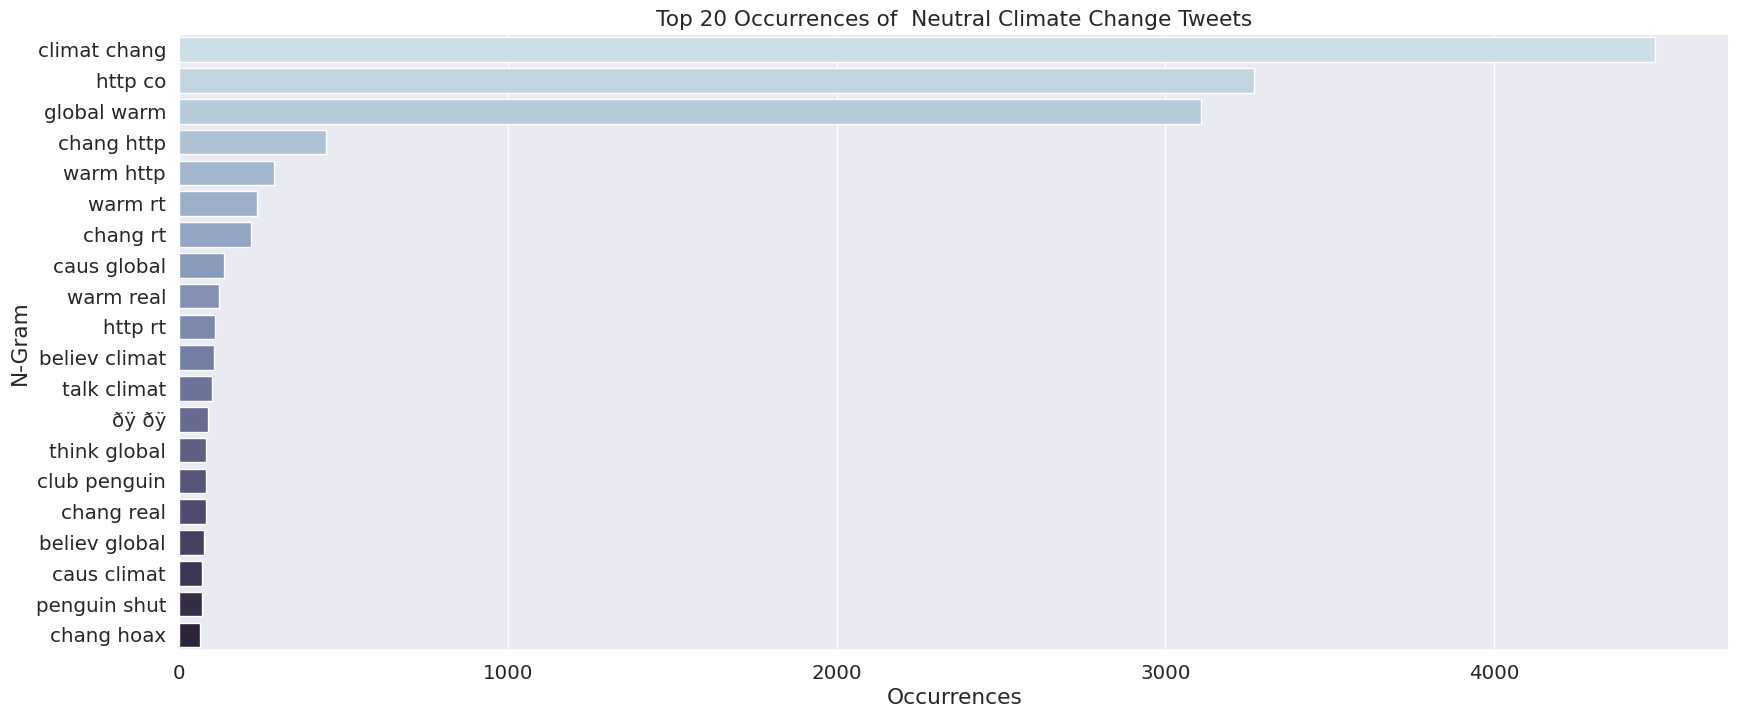

In [ ]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of  Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")

### Top 20 Occurrences of  Pro Climate Change Tweets (1)


***N-Gram (Sentiment: 1)
                   N-Gram  Occurrences
0            climat chang        19124
1                 http co        12378
2             global warm         3851
3              chang http         2799
4           believ climat         1427
5            fight climat          836
6                 http rt          788
7            chang denier          711
8              chang real          679
9                  go die          540
10               think go          514
11         husband believ          512
12            die husband          510
13     rt stephenschlegel          507
14  stephenschlegel think          507
15             co sjofonã          506
16              warm http          494
17               chang rt          477
18            deni climat          448
19             sjofonã rt          435


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

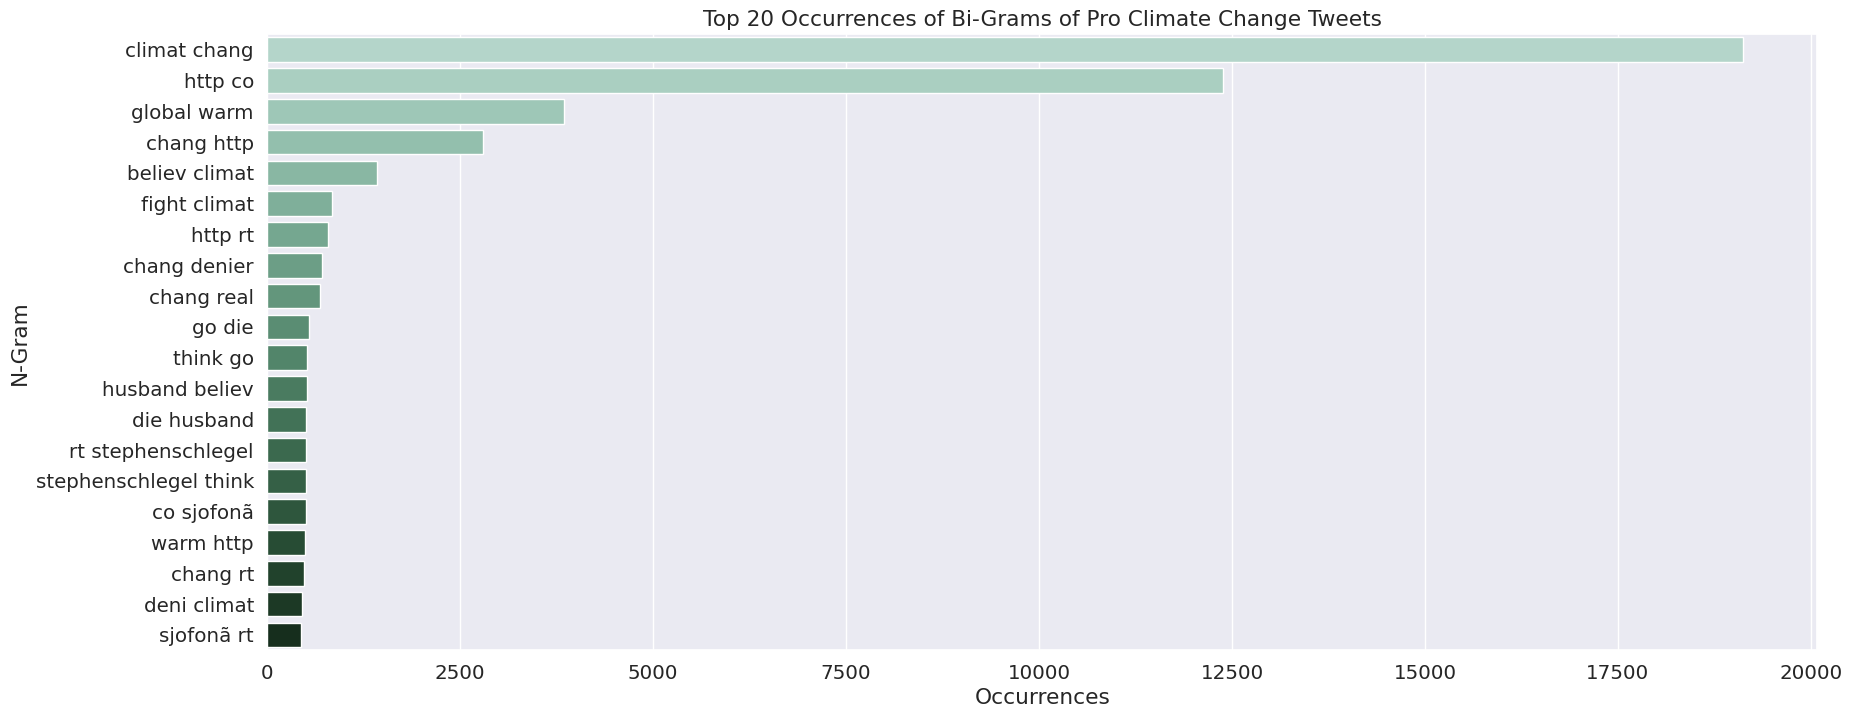

In [ ]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of  Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8")

### Top 20 Occurrences of Bi-Grams of Factual Climate Change Tweets (2)


***N-Gram (Sentiment: 2)
          N-Gram  Occurrences
0        http co        10199
1   climat chang         8102
2     chang http         2000
3    global warm         1196
4   fight climat          356
5      warm http          350
6   donald trump          269
7   trump climat          248
8        http rt          244
9   scott pruitt          218
10     rt thehil          208
11     epa chief          150
12   pari climat          129
13  tackl climat          126
14    say climat          126
15         co rt          126
16      say http          126
17    due climat          122
18     news http          121
19  chang polici          118


<Axes: title={'center': 'Top 20 Occurrences of  News Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

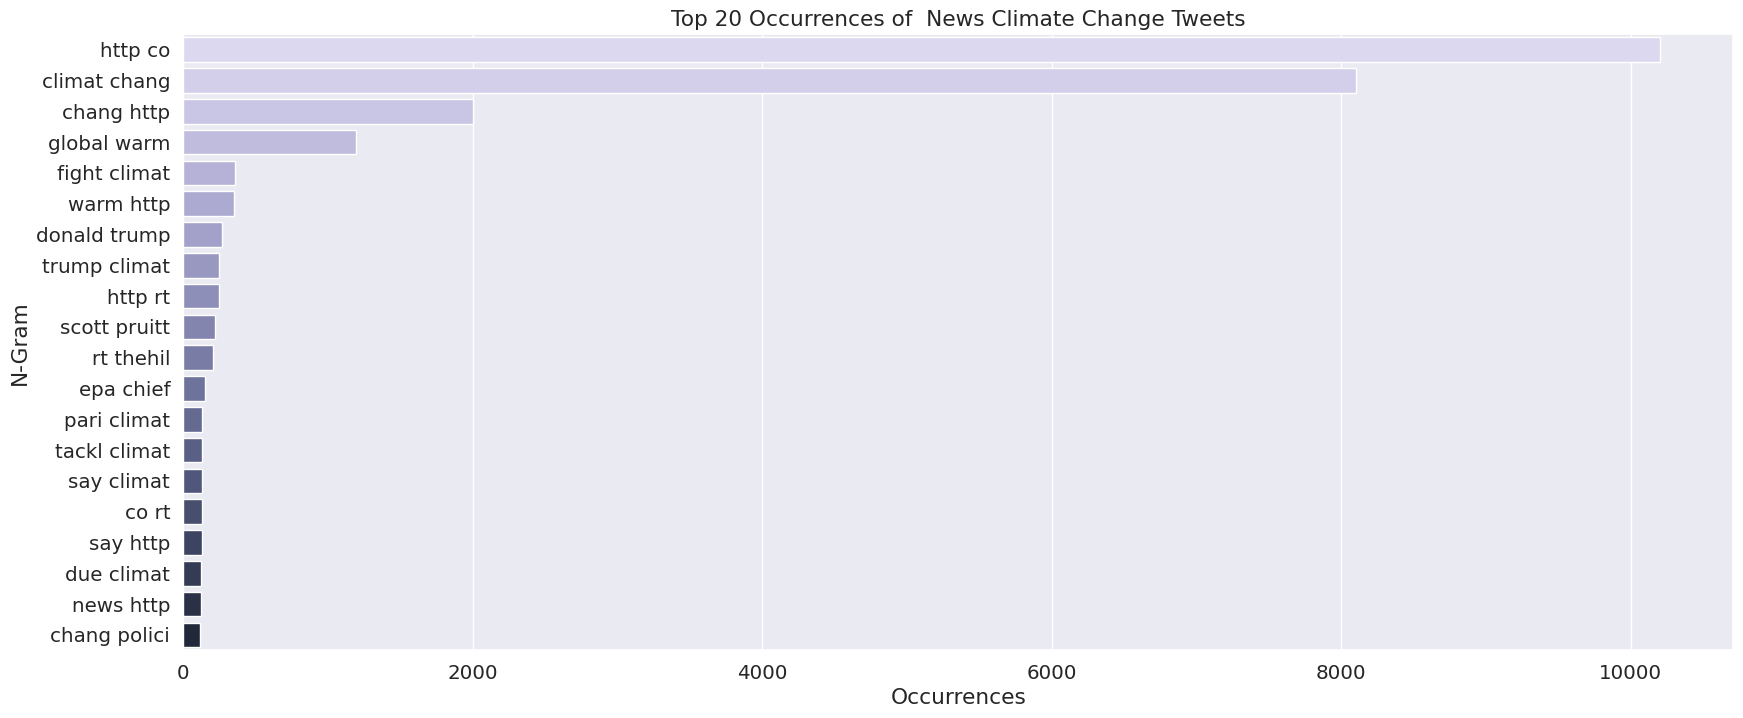

In [ ]:
counterDfNews = generateWordList(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNews.head(20)
print(counterDfNewsTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of  News Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="ch:2.8, r=.1")

## Tri-Grams


In [ ]:
SIZE = 3

## Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets (-1)


***N-Gram (Sentiment: -1)
                 N-Gram  Occurrences
0     climat chang http          146
1         chang http co          138
2      global warm http          112
3          warm http co          105
4     made climat chang           82
5       man made climat           78
6        global warm rt           71
7      made global warm           71
8       man made global           67
9     climat chang real           65
10      climat chang rt           61
11     global warm hoax           60
12   global warm climat           59
13    climat chang hoax           52
14  believ climat chang           52
15    warm climat chang           50
16     global warm data           45
17    caus climat chang           44
18     caus global warm           44
19    global warm creat           43


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

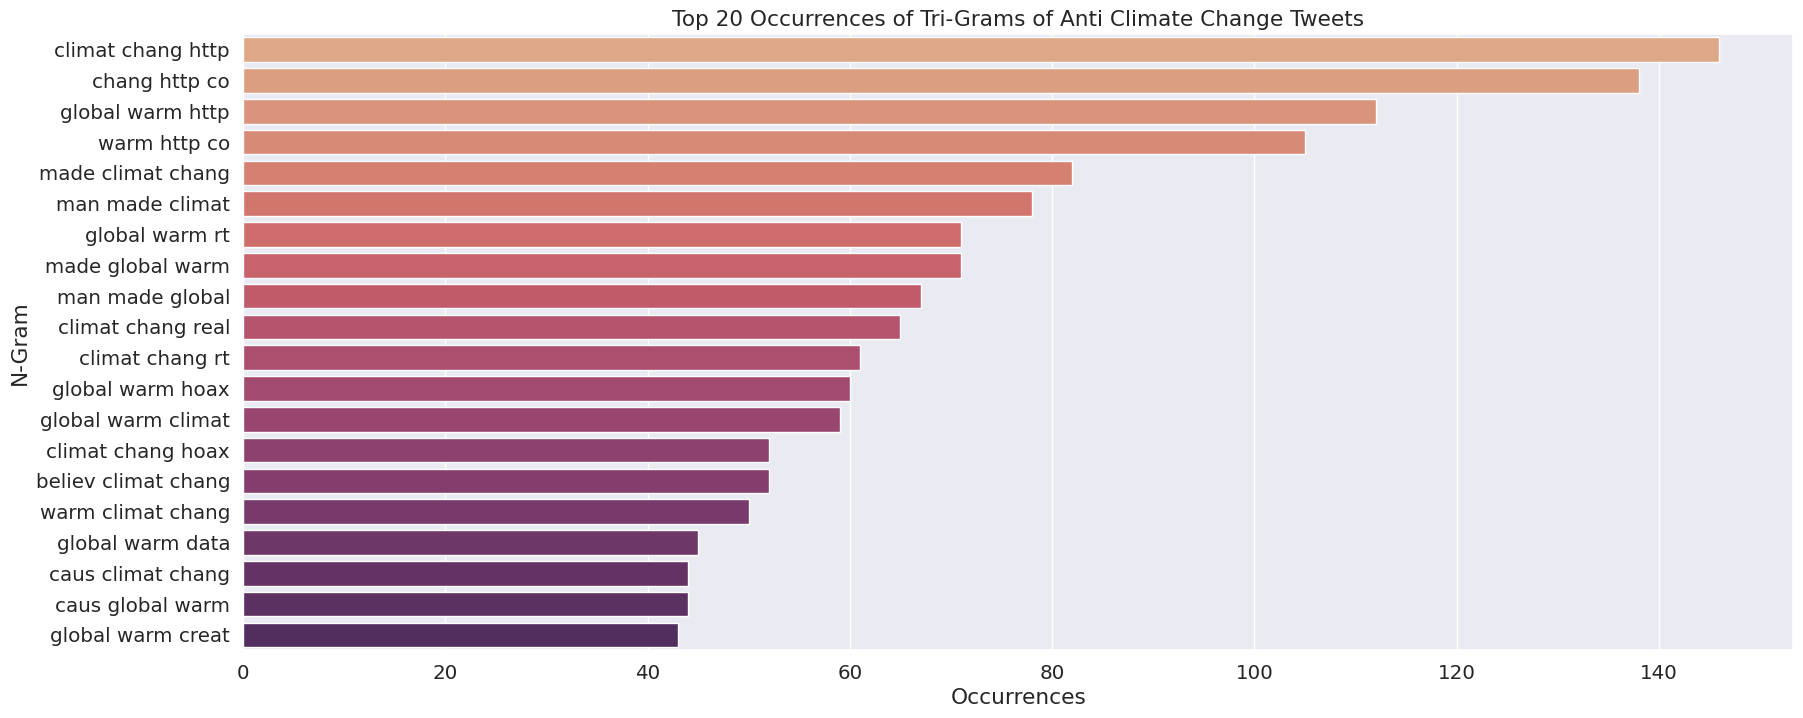

In [ ]:
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")

### Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets (0)


***N-Gram (Sentiment: 0)
                 N-Gram  Occurrences
0     climat chang http          444
1         chang http co          424
2      global warm http          289
3          warm http co          280
4        global warm rt          235
5       climat chang rt          214
6      caus global warm          137
7      global warm real          121
8   believ climat chang          106
9     talk climat chang           96
10    think global warm           81
11    climat chang real           81
12   believ global warm           74
13    caus climat chang           69
14    club penguin shut           68
15    climat chang hoax           63
16   think climat chang           58
17     stop global warm           57
18   fight climat chang           56
19     say climat chang           52


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

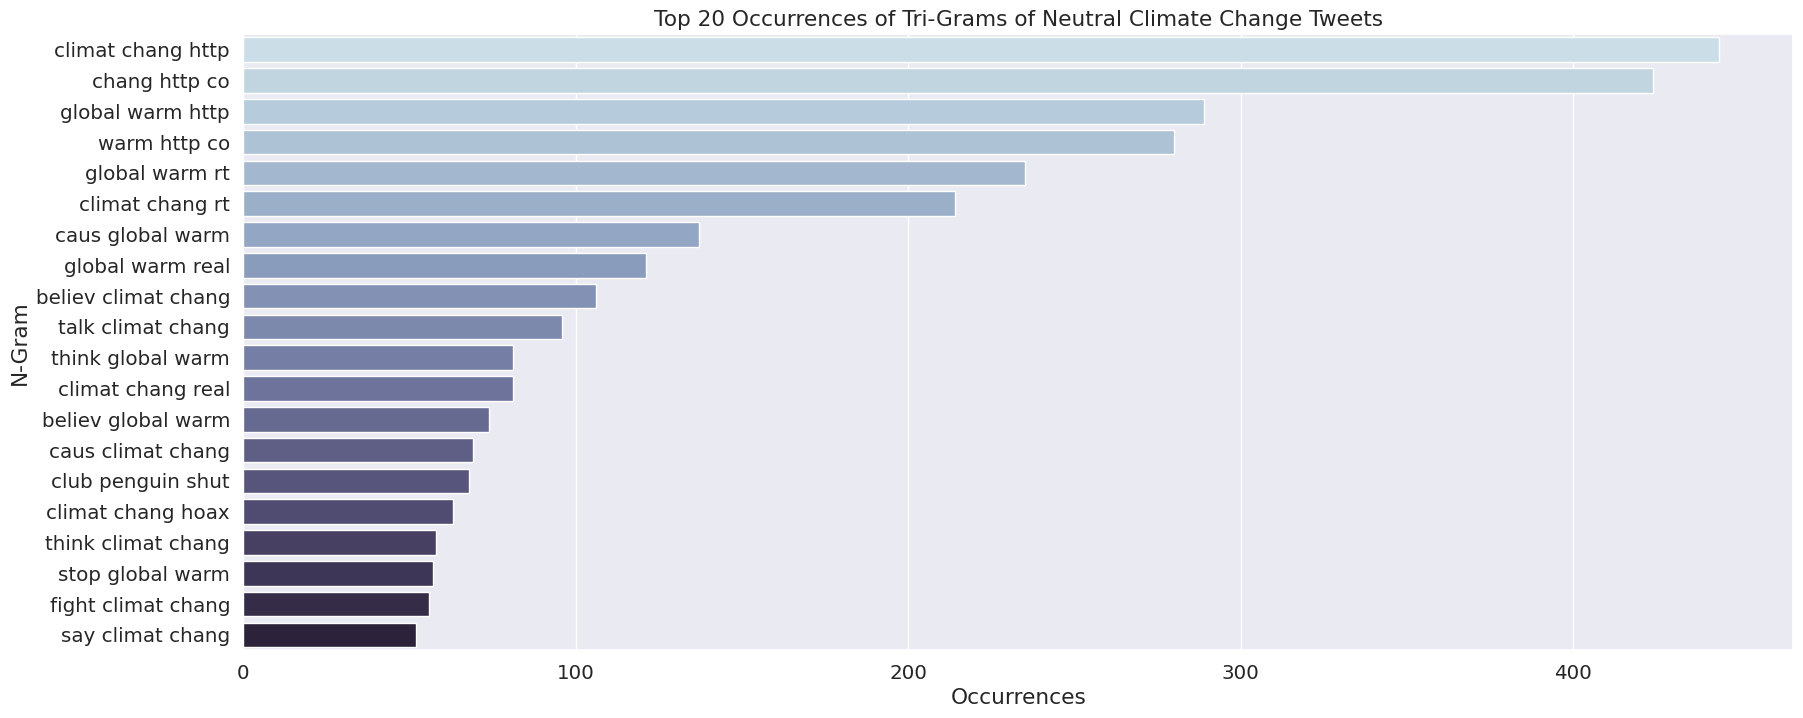

In [ ]:
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")

### Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets (1)


***N-Gram (Sentiment: 1)
                      N-Gram  Occurrences
0          climat chang http         2787
1              chang http co         2635
2        believ climat chang         1422
3         fight climat chang          822
4        climat chang denier          711
5          climat chang real          679
6      husband believ climat          512
7               think go die          510
8             go die husband          510
9         die husband believ          510
10  rt stephenschlegel think          507
11  stephenschlegel think go          507
12           http co sjofonã          506
13          global warm http          480
14              warm http co          470
15           climat chang rt          465
16             co sjofonã rt          435
17         deni climat chang          428
18        tackl climat chang          385
19       combat climat chang          366


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

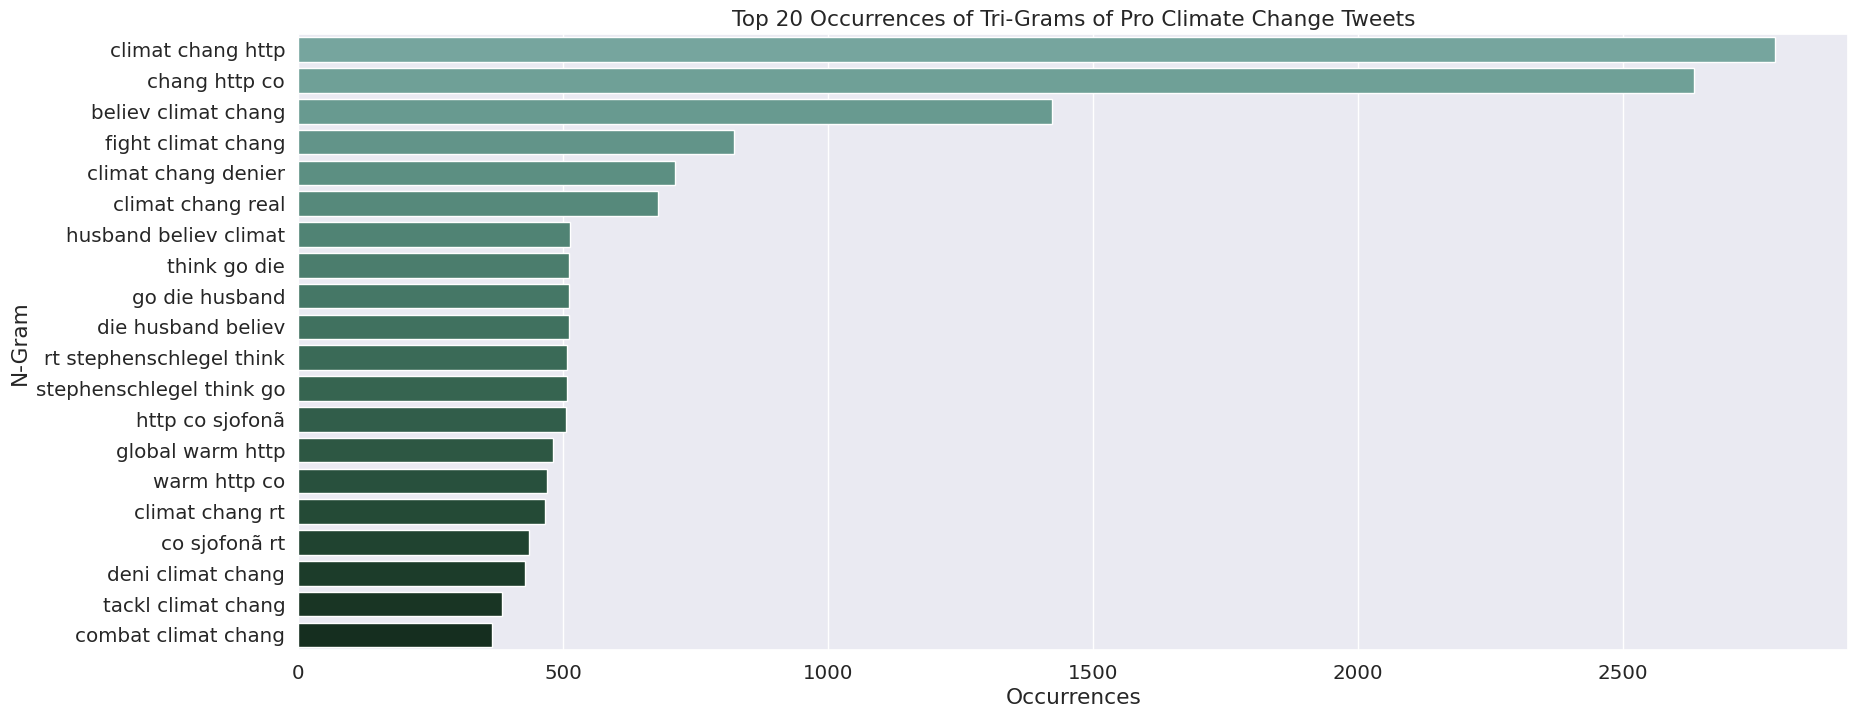

In [ ]:
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")

### Top 20 Occurrences of Tri-Grams of Factual Climate Change Tweets (2)


***N-Gram (Sentiment: 2)
                    N-Gram  Occurrences
0        climat chang http         1998
1            chang http co         1964
2       fight climat chang          355
3         global warm http          348
4             warm http co          346
5       trump climat chang          244
6               http co rt          126
7       tackl climat chang          125
8         say climat chang          124
9         due climat chang          122
10            news http co          121
11             say http co          121
12       pari climat chang          117
13     climat chang polici          116
14     action climat chang           96
15     effect climat chang           88
16      climat chang could           82
17           studi http co           81
18  climat chang agreement           80
19       talk climat chang           79


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of News Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

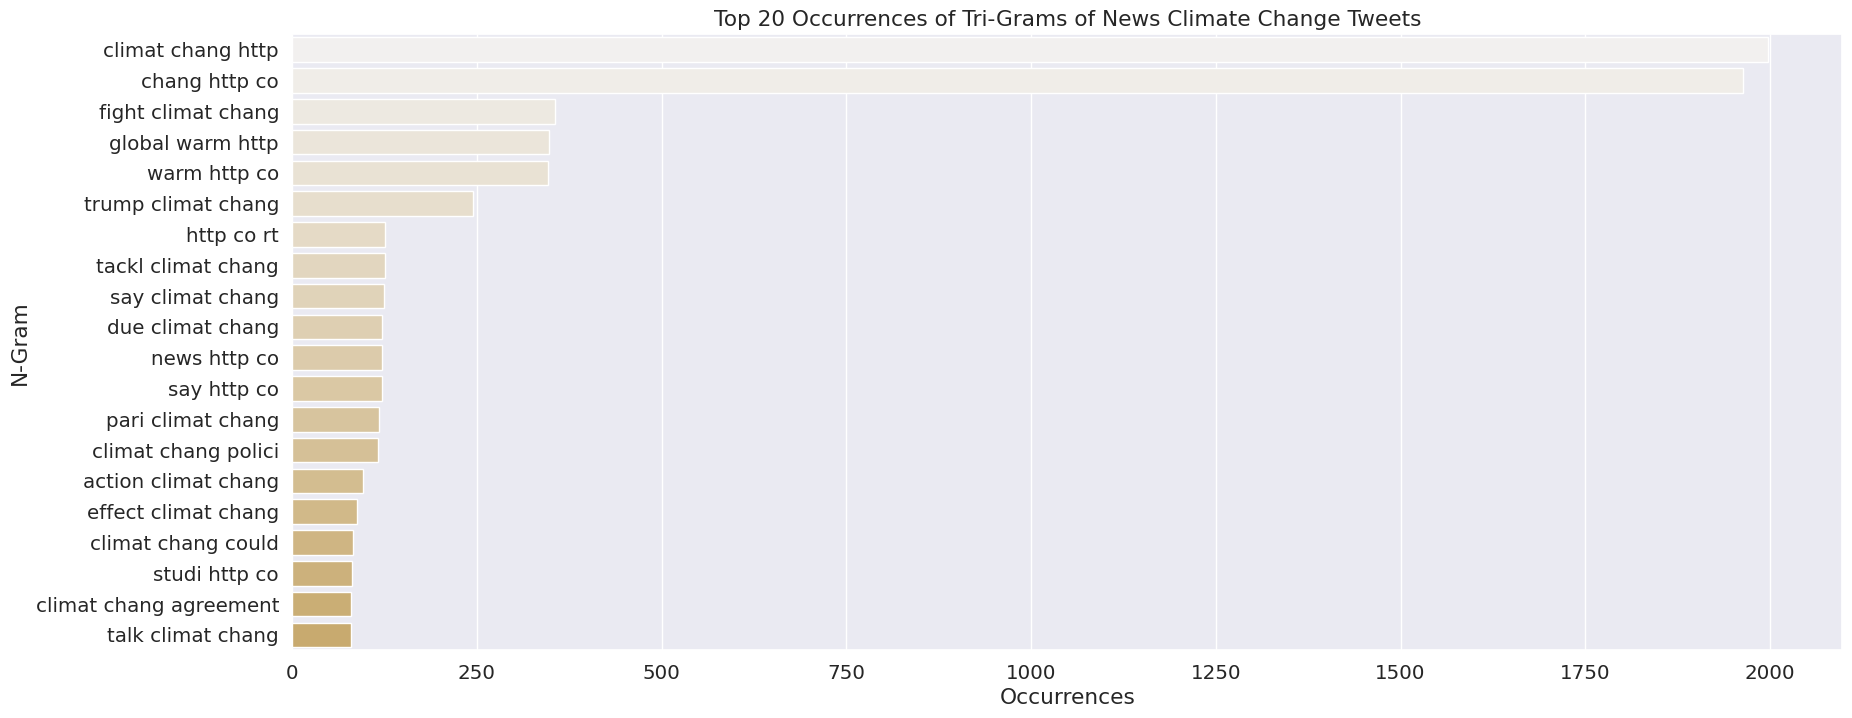

In [ ]:
counterDfNews = generateWordList(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNews.head(20)
print(counterDfNewsTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of News Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="light:#D7AF60")

# Machine Learning Models


In [ ]:
def evaluateModel(model, X_test, y_test, title):

    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average='weighted')
    precision = metrics.precision_score(y_test, predictions, average='weighted')
    f1 = metrics.f1_score(y_test, predictions, average='weighted')

    clsScoreDict = {
        "accuracy": accuracy
        , "recall": recall
        , "precision": precision
        , "f1": f1
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [ ]:
def modelAndPredict(X, target, model):
  

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)


    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [ ]:
def showFormattedConfusionMatrix(y_test, y_predicted):

    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = ['Actual -1', 'Actual 0', 'Actual 1', 'Actual 2', ]
    Cols = ['Pred -1', 'Pred 0', 'Pred 1', 'Pred 2']
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))

    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set(title="Movie Review Sentiment")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30,
                       horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0,
                       horizontalalignment='right')

In [ ]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [ ]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [ ]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

##  Machine Learning with  Logistic Regression Model

In [ ]:
model = LogisticRegression()

In [ ]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)



*** LogisticRegression ***
Accuracy:  0.7340251228836702
Precision: 0.727630708755521
Recall:    0.7340251228836702
F1:        0.7290325016521769





/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(vectorizedTweets2, df['sentiment'], model)



*** LogisticRegression ***
Accuracy:  0.703531767704351
Precision: 0.7026283671167339
Recall:    0.703531767704351
F1:        0.6861763410435947





/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(vectorizedTweets3, df['sentiment'], model)



*** LogisticRegression ***
Accuracy:  0.661751319861642
Precision: 0.6710263130666225
Recall:    0.661751319861642
F1:        0.6248905823733565





/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(vectorizedTweets23, df['sentiment'], model)



*** LogisticRegression ***
Accuracy:  0.6922446750409612
Precision: 0.6936486331200745
Recall:    0.6922446750409612
F1:        0.6742805393943099





/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Comparisons in Logistic Regression


In [ ]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["-"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat([lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf23])
lsScoreComparisonDf

,accuracy,recall,precision,f1
-,0.734025,0.734025,0.727631,0.729033
Bi-gram,0.703532,0.703532,0.702628,0.686176
Tri-gram,0.661751,0.661751,0.671026,0.624891
Bi-gram and Tri-gram,0.692245,0.692245,0.693649,0.674281


### 2. Tweet ML with Decision Tree

In [ ]:
model = DecisionTreeClassifier(max_depth=20)

In [ ]:
X_test, y_test, y_predicted, treeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)



*** DecisionTreeClassifier ***
Accuracy:  0.607591480065538
Precision: 0.6246978913593904
Recall:    0.607591480065538
F1:        0.5516402556685452





## 3. Tweet ML with Random Forest Classifier

In [ ]:
model = RandomForestClassifier()

In [ ]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)



*** RandomForestClassifier ***
Accuracy:  0.7024394684143456
Precision: 0.7095235522502173
Recall:    0.7024394684143456
F1:        0.6808298650332357





## 4. Tweet ML with K Neighbors Classifier

In [ ]:
model = KNeighborsClassifier()

In [ ]:
X_test, y_test, y_predicted, knnScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)



*** KNeighborsClassifier ***
Accuracy:  0.4338248680138358
Precision: 0.5941233044388676
Recall:    0.4338248680138358
F1:        0.44802360352791554





## 5. Tweet ML with Linear Support Vector Classifier (SVC)

In [ ]:
model = SVC()

In [ ]:
X_test, y_test, y_predicted, svcScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)



*** SVC ***
Accuracy:  0.7271072273803022
Precision: 0.7308060685011033
Recall:    0.7271072273803022
F1:        0.7101206343061786





# TWEET ML RESULTS of : Model Comparisons

In [ ]:
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression"])
treeScoreDf = pd.DataFrame(treeScoreDict, index=["Decision Tree"])
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest Classification"])
knnScoreDf = pd.DataFrame(knnScoreDict, index=["K Neighbors Classification"])
svcScoreDf = pd.DataFrame(svcScoreDict, index=["Linear Support Vector Classifier Classification"])


clsCompDf = pd.concat([lrScoreDf, treeScoreDf, rfScoreDf,  knnScoreDf, svcScoreDf])

clsCompDf.sort_values(by=["accuracy", "f1"], ascending = False)

,accuracy,recall,precision,f1
Logistic Regression,0.734025,0.734025,0.727631,0.729033
Linear Support Vector Classifier Classification,0.727107,0.727107,0.730806,0.710121
Random Forest Classification,0.702439,0.702439,0.709524,0.680830
Decision Tree,0.607591,0.607591,0.624698,0.551640
K Neighbors Classification,0.433825,0.433825,0.594123,0.448024
